# **Introduction**

In this notebook, we're going to calculate the dynamics of a quenched Heisenberg quantum spin lattice. To do that, we'll use several differrent methods:
- Exact Diagonalization (ED) as a benchmark,
- Gradient descent for optimization of the ground state,
- Time-Dependent Variational Principle (TDVP) for obtaining variational dynamics.

Let's start by including all the code we'll use in the notebook, and setting some basic properties.

---

In [ ]:
# import everything you need
from src import *
import matplotlib.pyplot as plt

# set plot properties
# NOTE: to use this setting, you'll need to have TeX installed (remove or comment if you don't have it)
plt.rcParams.update({'font.size': 25,
                     'font.family': 'Candara',
                     'text.usetex': True
                     })

# notebook code reloading
# NOTE: if this casts an error, remove or comment it
%load_ext autoreload
%autoreload 2

Now, let's set up some basic properties of the physical system and the (hyper)parameters of the code.

# **Settings**

We start by building a lattice which will be used in all of our calculations. We need to set the dimensions `Lx` and `Ly`, and then use the `hilbert.lattice` class to create it.

Next, we need hyperparameters for the ground state optimization. For our purposes, only the learning rate `eta` is enough.

Next, we need to specify the parameters for dynamics calculations:
- `steps`: number of integration steps,
- `endtime`: final time of the calculations, in the unit $1/J_0$. Time step `dt` is calculated from `steps` and `endtime`,
- `quench`: driving function that give the time dependence of the perturbation - we're keeping it a simple quench of $0.5$ (unit of $J_0$)

Finally, for postprocessing, we need to specify for which lattice `links` are we calculating correlation functions. The lattice labeling is always flattened. This is always passed as a list.

In [4]:
# for the lattice
Lx, Ly = 2,2 # dimensions
lat = hilbert.lattice(Lx, Ly) # the lattice class

# for the network
alpha = 1/4

# for ground state optimization
eta = 0.01

# for dynamics
steps = 2000
endtime = 2
quench = lambda t: 0.5 # a nice quench value

# links to process
# in the flattened labeling of a 2x2 lattice, the (0,2) link is along a quenched bond
links = [(0,2)]

# <span style='color: lightblue'> **Exact diagonalization** </span>

Let's first make the entire benchmark calculation. We'll use the `exact.ED` class, to which we need to pass:
- lattice `lat`,
- integration `steps`,
- final time `endtime`,
- driving function `quench`.

We run the calculation with the `run()` class method.


In [5]:
# declare the ED calculation
ed = exact.ED(lat, steps, endtime, perturbator=quench)

# run it
ed.run()

As a reality check, we can plot some results of this calculation. Energy and the correlation function along a quenched bond `(0,2)` are a good example.

The `ED` class saves various values of the calculation. We'll use the `times` list to get the values of times. To get the observables, we access a class property `observables`, which is a dictionary keyed by strings denoting observables. For the energy, we access: 
```python
ed.observables['energy']
```
All the correlations are written in a nested dictionary `[correlations]`, and keyed by their bond indices tuples. Therefore, to get the quenched bond correlation, we use:
```python
ed.observables['correlations'][(0,2)]
```

## Energy

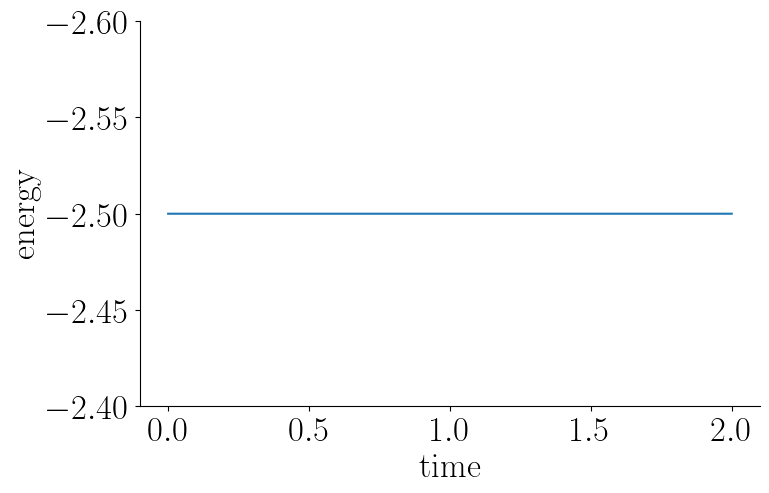

In [11]:
# some plot settings
plt.figure(figsize=(8,5))

# plot
# NOTE: the times array has one extra value (technical reasons), so we'll just exclude the first one from the list.
plt.plot(ed.times[1:], ed.observables['energy'])

# y limits
plt.ylim([-2.4, -2.6])

# labels
plt.xlabel("time")
plt.ylabel("energy")

# aesthetics
plt.gca().spines[['top', 'right']].set_visible(False)

We can see that the energy is very nicely conserved at $-2.5$ value.

## Correlation

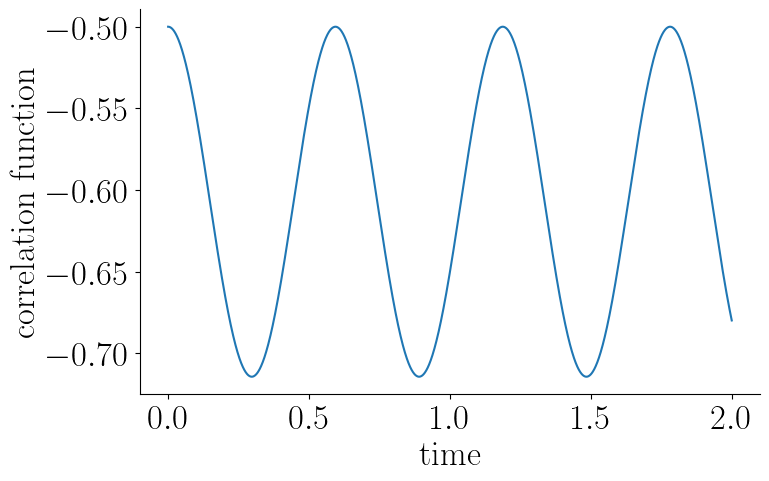

In [12]:
# some plot settings
plt.figure(figsize=(8,5))

# plot
plt.plot(ed.times, ed.observables['correlations'][(0,2)])

# labels
plt.xlabel("time")
plt.ylabel("correlation function")

# aesthetics
plt.gca().spines[['top', 'right']].set_visible(False)

The correlation function between two spins along a quenched bond oscillates in time. 

# <span style='color: lightgreen'> **Ground state** </span>

Now let's use the Neural Quantum States (NQS) method with the Restricred Boltzmann Machine (RBM) architecture to calculate the variational representation of the ground state. This is done by optimizing the energy of the Heisenberg model by a gradient descent algorithm.

We'll use the `groundstate.descent` class, to which we need to pass:
- lattice `lat`,
- neural network width `alpha`,
- learning rate `eta`.

We can start the optimization by using the `optimize` method, initialized with a random state. The optimization will stop by itself once it has reached proper convergence. But, to get a better visual data, we'll set the option `miniter = 1000` to declare a minimum of $1000$ optimization steps.

In [ ]:
# declare
gs = groundstate.descent(lat, alpha, eta)

# run
gs.optimize(miniter=1000)

iteration 100 ... energy:  -1.9999995823654684
iteration 200 ... energy:  -1.9999998005003665
iteration 300 ... energy:  -1.9999999314094232
iteration 400 ... energy:  -1.99999998454423
iteration 500 ... energy:  -1.999999997424341
iteration 600 ... energy:  -1.9999999996912354
iteration 700 ... energy:  -1.9999999999869198
iteration 800 ... energy:  -1.999999999999723
iteration 900 ... energy:  -1.9999999999999938
iteration 1000 ... energy:  -2.0000000000000004


Let's plot the loss funciton of the gradient descent, which is energy. It's written in the `loss` list of the class.

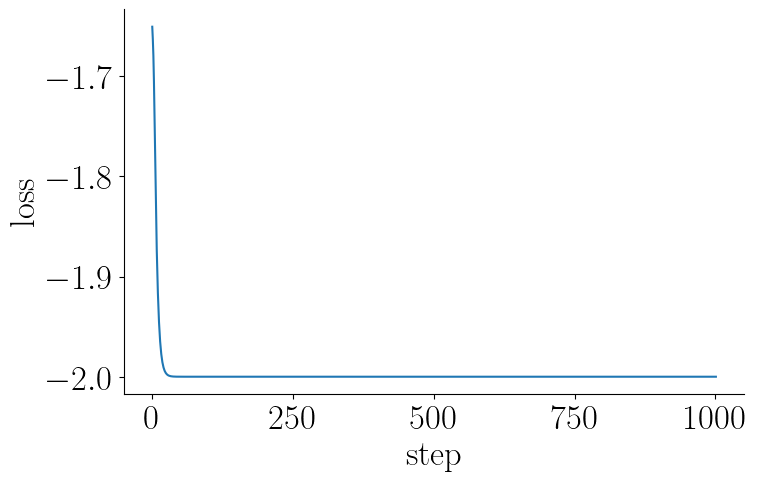

In [20]:
# some plot settings
plt.figure(figsize=(8,5))

# plot
plt.plot(gs.loss)

# labels
plt.xlabel("step")
plt.ylabel("loss")

# aesthetics
plt.gca().spines[['top', 'right']].set_visible(False)

From the graph, it's clear that the energy converges quite quickly. If we want to see the parameters of this ground state, we can access them through the `states` list. Each state in the list is a `numpy` array of network parameters.

In [18]:
gs.states[-1]

array([ 1.05949720e-16+0.j,  3.30764544e-01+0.j, -3.24308711e-01+0.j,
       -3.24306726e-01+0.j,  3.37604930e-01+0.j])

# <span style='color: orange'> **Dynamics** </span>

Finally, let's see how to calculate the TDVP dynamics. We'll use the `dynamics.evolution` class.

Some basic settings that the calss requires are:
- lattice `lat`,
- network width `alpha`,
- initial state: we'll use the last obtained state from the ground state object `gs`,
- integration `steps`,
- final time `endtime`,
- driving function, which is passed into the `perturbator` argument

Additionally, we can specify the following integrational hyperparameters:
- `integrator`: which scheme is used to obtain new network parameters in each step,
- `formulation`: denotes a way to calculate the inverse of the $S$-matrix.

Currently, the code includes the choice between two **integrators**: `'heun'` and `'implicit_midpoint'`, and three **formulations**: `'regularization'`, `'diagonalization'`, and `'geometric'`. Please note that they have to be passed as strings to their respective keyword arguments.
Let's run the dynamis with the `'heun'` integrator in the `'regularization'` formulation, using a regulator of $\varepsilon = 10^{-5}$.

We can run the class by using the `.run` method.

In [ ]:
# declare the dynamics class
dyn = dynamics.evolution(lat, alpha, # system settings
                         gs.states[-1].copy(), steps, endtime, # dynamics settings
                         perturbator = quench, # driving (use the same one as with ED)
                         integrator = 'heun', # this is a default option
                         formulation='regularization', regulator = 1e-5)

# run it
dyn.run()

running simmulation...


100%|██████████| 2000/2000 [00:23<00:00, 86.28it/s] 


When the simulation is done, let's see some results.

## Energy

In the `evolution` class, time and energy are stored in their own lists, `times` and `energies`, respectively. We can ignore the first values of both, as they are just the ground state.

We can compare the energy with the results from the benchmark ED run.

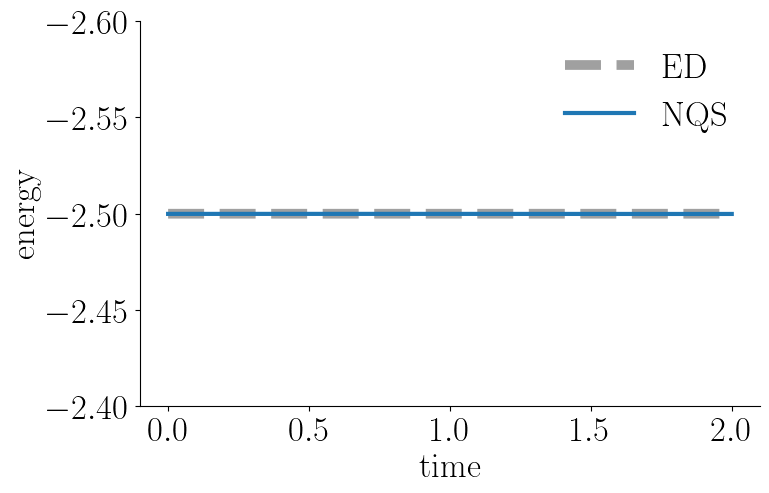

In [ ]:
# some plot settings
plt.figure(figsize=(8,5))

# plot benchmark ED
plt.plot(ed.times[1:], ed.observables['energy'], 
         lw = 7, color = 'gray', alpha = 0.75, ls = '--', # line settings
         label = 'ED')

# plot NQS run
plt.plot(dyn.times[1:], dyn.energies[1:], lw = 3, 
         label = 'NQS')

# y limits
plt.ylim([-2.4, -2.6])

# labels
plt.xlabel("time")
plt.ylabel("energy")

# aesthetics
plt.legend(frameon = False)
plt.gca().spines[['top', 'right']].set_visible(False)

The energy is also nicely conserved, as we expected.

## Correlation

In the `evolution` class, all correlations are stored in the `correlations` dictionary, keyed by the bond-index-pair tuples. However, we must first calculate the correlation time series. We use the `process_links` method, which requires a list of links to process. We aready defined this list of `links` that contains only the `(0,2)` bond.

In [36]:
# process links
dyn.process_links(links)

calculating correlations at links: [(0, 2)]


100%|██████████| 2001/2001 [00:01<00:00, 1009.99it/s]


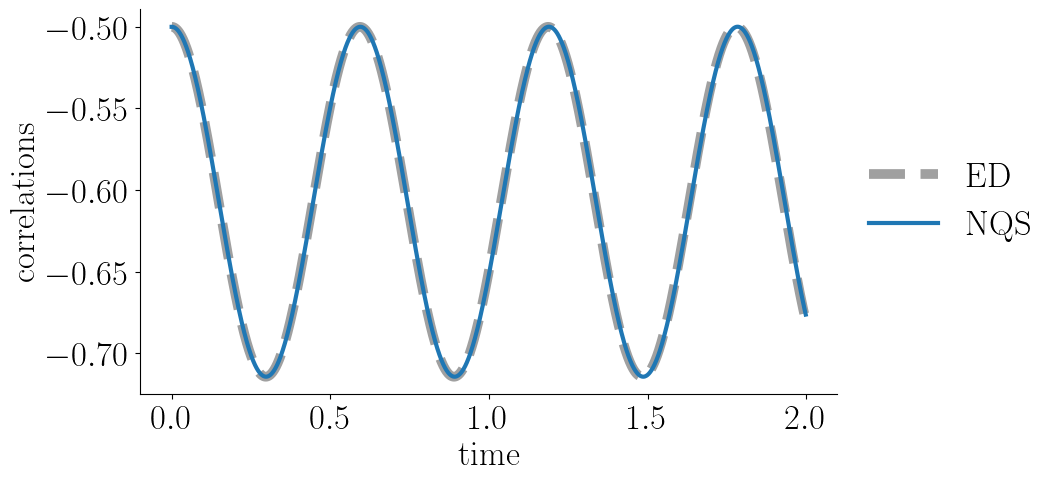

In [ ]:
# some plot settings
plt.figure(figsize=(9,5))

# plot benchmark ED
plt.plot(ed.times, ed.observables['correlations'][(0,2)], 
         lw = 7, color = 'gray', alpha = 0.75, ls = '--', # line settings
         label = 'ED')

# plot NQS run
plt.plot(dyn.times, dyn.correlations[(0,2)], lw = 3, 
         label = 'NQS')

# labels
plt.xlabel("time")
plt.ylabel("correlations")

# aesthetics
plt.legend(frameon = False,  bbox_to_anchor=(1, 0.5), loc='center left')
plt.gca().spines[['top', 'right']].set_visible(False)

The correlation oscillations of the NQS simulation follow the exact solutions quite nicely! 

## Spectrum

Another important property of the NQS calculations are the eigenvalues of the $S$-matrix. We can access them from the class property `spectrum`. Again, we need to analyse the spectrum with the `process_spectrum` method.

In [ ]:
# process it
dyn.process_spectrum()

calculating spectrum dynamics of the S-matrix


100%|██████████| 2001/2001 [00:01<00:00, 1018.92it/s]


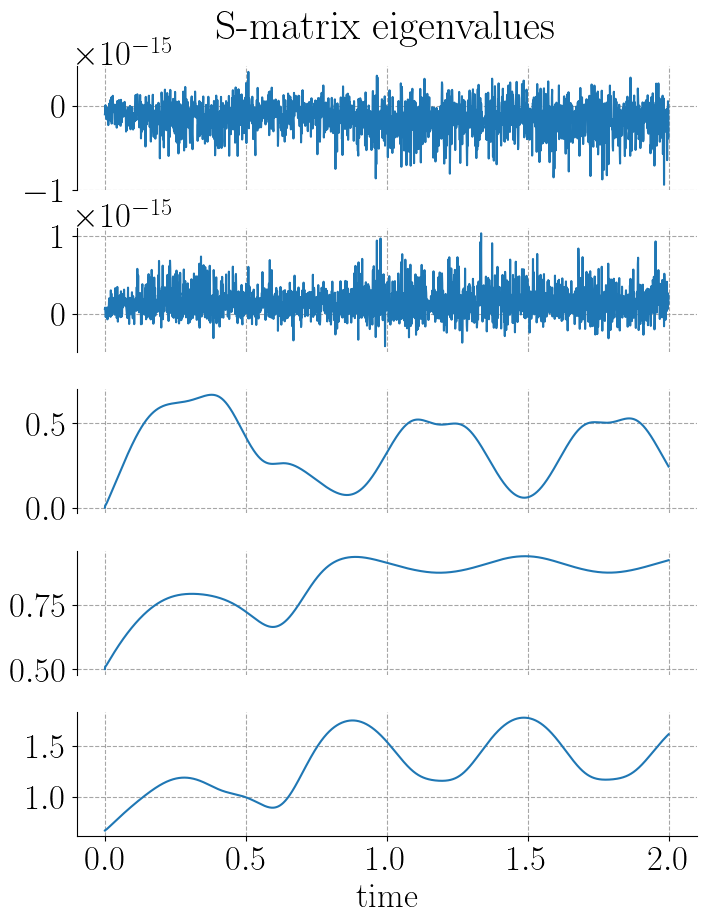

In [52]:
# plot it

# plot settings
fig, axes = plt.subplots(5, 1, figsize = (8, 10), sharex = True)
plt.subplots_adjust(hspace=0.3)

# plot it
for i in range(len(dyn.spectrum)):
    axes[i].plot(dyn.times, dyn.spectrum[i])

# labels and titles
axes[0].set_title("S-matrix eigenvalues", pad = 20)
axes[-1].set_xlabel("time")

# aesthetics: graph spines
for i in range(len(axes)-1):
    axes[i].spines[['bottom', 'right', 'top']].set_visible(False)
    axes[i].tick_params(axis='x', length=0)
axes[-1].spines[['right', 'top']].set_visible(False)

# aesthetics: grids
for ax in axes:
    ax.grid(True, which='both', linestyle='--', color='gray', alpha=0.7)

It's quite clear that two of the eigenvalues are zero in machine precision, while other have nice, well-behaved values.